In [1]:
import random as rd
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt

#submit = True
submit = False

In [2]:
# load the public MNIST dataset.
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train_norm = x_train/255.
x_test_norm = x_test/255.

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
#kaggle = pd.read_csv('../input/digit-recognizer/test.csv')
kaggle = pd.read_csv('https://github.com/davidabelin/kaggle-files/raw/main/digit-recognizer/test.csv')
kaggle_norm = np.asarray(kaggle/255.)

k_train = pd.read_csv('https://github.com/davidabelin/kaggle-files/raw/main/digit-recognizer/train.csv')
k_labels = np.asarray(k_train['label'])
k_train = k_train.drop(columns=['label'])
k_train_norm = np.asarray(k_train/255.)

In [4]:
# Add a channels dimension
k_train_norm = k_train_norm.reshape(42000, 28, 28, 1)
kaggle_norm = kaggle_norm.reshape(28000, 28, 28, 1)
x_train_norm = x_train_norm.reshape(60000, 28, 28, 1)
x_test_norm = x_test_norm.reshape(10000, 28, 28, 1)

In [5]:
# train on the training set with some held back for validation #
def train_model(model, train_features, train_label, epochs,
                batch_size=None, validation_split=None):

    history = model.fit(x=train_features, y=train_label, 
                        batch_size=batch_size,
                        epochs=epochs, shuffle=True, 
                        validation_split=validation_split,
                        verbose = 1)

    # Gather the model's metrics after each round of training
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    return epochs, hist

In [6]:
 # Set up a CNN with Keras
 
def create_CNN(learning_rate):
    """Create and compile a convolutional neural net."""  
    # Define the kind of model to use.
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, 6, activation='relu', input_shape=(28, 28, 1)))
    model.add(tf.keras.layers.Conv2D(64, 4, activation='relu'))
    model.add(tf.keras.layers.Conv2D(128, 2, activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2,2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=100, activation='softmax'))     
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                    loss="sparse_categorical_crossentropy",
                    metrics=['accuracy']) 
    return model

In [7]:
# Train and evalate CNN on ALL the datasets, 
# Train on 10000 + 60000 + 42000 to predict on 28000
learning_rate = 0.001
epochs = 5
batch_size = 500
validation_split = 0.005 # 0.5% off bottom of each array
start_time = time.time()

convoluter = create_CNN(learning_rate)
 
# TRAIN X8:
for _ in range(8): #40 epochs total on each dataset
    #x_test_norm:
    epochs_CNN1, hist_CNN1 = train_model(convoluter, x_test_norm, y_test, epochs, batch_size, validation_split)
    print("\nFinished test set of 10000 in about {} seconds\n".format((round(time.time()-start_time,4))))
    batch_time = time.time()
    #x_train_norm:
    epochs_CNN2, hist_CNN2 = train_model(convoluter, x_train_norm, y_train, epochs, batch_size, validation_split)
    print("\nFinished test set of 60000 in about {} seconds\n".format((round(time.time()-start_time,4))))
    batch_time = time.time()
    #k_train_norm:
    epochs_CNN3, hist_CNN3 = train_model(convoluter, k_train_norm, k_labels, epochs, batch_size, validation_split)
    print("\nfinished test set of 42000 in about {} seconds\n".format((round(time.time()-start_time,4))))

print ("\nTotal time: {} seconds is about {} minutes.".format(round(time.time()-start_time,4),
                                                              (time.time()-start_time)//60))

Epoch 1/5
20/20 [==============================] - 1s 35ms/step - loss: 1.7508 - accuracy: 0.5117 - val_loss: 0.6617 - val_accuracy: 0.7600
Epoch 2/5
20/20 [==============================] - 0s 18ms/step - loss: 0.4260 - accuracy: 0.8760 - val_loss: 0.4153 - val_accuracy: 0.9000
Epoch 3/5
20/20 [==============================] - 0s 18ms/step - loss: 0.2676 - accuracy: 0.9214 - val_loss: 0.3055 - val_accuracy: 0.9200
Epoch 4/5
20/20 [==============================] - 0s 18ms/step - loss: 0.1871 - accuracy: 0.9438 - val_loss: 0.2032 - val_accuracy: 0.9400
Epoch 5/5
20/20 [==============================] - 0s 18ms/step - loss: 0.1336 - accuracy: 0.9595 - val_loss: 0.2185 - val_accuracy: 0.9400

Finished test set of 10000 in about 9.9586 seconds

Epoch 1/5
120/120 [==============================] - 2s 18ms/step - loss: 0.1096 - accuracy: 0.9674 - val_loss: 0.2675 - val_accuracy: 0.9533
Epoch 2/5
120/120 [==============================] - 2s 18ms/step - loss: 0.0660 - accuracy: 0.9804 - val

In [10]:
convoluter.evaluate(x_test_norm, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 8.6235e-05 - accuracy: 1.0000


[8.623475150670856e-05, 1.0]

In [ ]:
convoluter.save_model('digiteer')

In [8]:
if submit:
    
    def getKaggles():  
        kaggles = pd.DataFrame(columns=['ImageId','Label'])  
        predicts = convoluter.predict(kaggle_norm)
        for j in range(len(kaggle_norm)):
            probs = predicts[j] # one row of 10 probabilities 
            max_id = np.argmax(probs)   # index of top probability in row
            kaggles.at[j,'ImageId'] = j+1
            kaggles.at[j,'Label'] = max_id
        return kaggles
    
    kaggles = getKaggles()
    kaggles.to_csv('submission.csv', columns=["ImageId","Label"], index=False)

##Visualizations

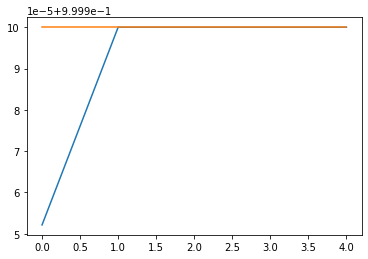

In [9]:
if not submit:
# Plot a graph of the 'accuracy' metric vs. epochs:
    plt.plot(epochs_CNN3,hist_CNN3["accuracy"])
    plt.plot(epochs_CNN3,hist_CNN3["val_accuracy"])